In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.optim import Adam
from torch.utils.data import DataLoader


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

In [ ]:
def matrix_to_grid_4d(matrix, grid_rows, grid_cols):
        """
        Divide un tensore 4D in una griglia di sotto-matrici (patch) non sovrapposte.

        Args:
            matrix (torch.Tensor): tensore 4D da dividere, di forma [N, C, H, W].
            grid_rows (int): numero di patch lungo l'asse verticale (altezza).
            grid_cols (int): numero di patch lungo l'asse orizzontale (larghezza).

        Returns:
            torch.Tensor: tensore contenente le patch, di forma [N, grid_rows*grid_cols, C, patch_height, patch_width].
        """
        # Ottieni le dimensioni del tensore
        N, C, H, W = matrix.shape
        # Calcola le dimensioni di ogni patch
        patch_h = H // grid_rows
        patch_w = W // grid_cols

        # Usa unfold sugli assi spaziali (H e W)
        patches = matrix.unfold(2, patch_h, patch_h).unfold(3, patch_w, patch_w)
        # Ora patches ha shape: [N, C, grid_rows, grid_cols, patch_h, patch_w]
        # Riorganizza le dimensioni: unisci grid_rows e grid_cols in una singola dimensione
        patches = patches.contiguous().view(N, C, grid_rows * grid_cols, patch_h, patch_w)
        # Se preferisci avere la dimensione dei canali subito dopo quella delle patch:
        patches = patches.permute(0, 2, 1, 3, 4)  # Shape finale: [N, grid_rows*grid_cols, C, patch_h, patch_w]
        return patches

def grid_to_matrix_4d(patches, grid_rows, grid_cols):
        """
        Ricostruisce il tensore originale a partire da una griglia di patch.

        Args:
            patches (torch.Tensor): tensore contenente le patch, di forma
                [N, grid_rows*grid_cols, C, patch_h, patch_w].
            grid_rows (int): numero di patch lungo l'asse verticale.
            grid_cols (int): numero di patch lungo l'asse orizzontale.

        Returns:
            torch.Tensor: tensore ricostruito, di forma [N, C, grid_rows*patch_h, grid_cols*patch_w].
        """
        N, num_patches, C, patch_h, patch_w = patches.shape
        if num_patches != grid_rows * grid_cols:
            raise ValueError("Il numero totale di patch deve essere grid_rows * grid_cols")

        # Rimodella in [N, grid_rows, grid_cols, C, patch_h, patch_w]
        patches = patches.view(N, grid_rows, grid_cols, C, patch_h, patch_w)
        # Permuta le dimensioni per posizionare correttamente le patch:
        # da [N, grid_rows, grid_cols, C, patch_h, patch_w] a [N, C, grid_rows, patch_h, grid_cols, patch_w]
        patches = patches.permute(0, 3, 1, 4, 2, 5).contiguous()
        # Combina le dimensioni spaziali per ricostruire il tensore originale
        return patches.view(N, C, grid_rows * patch_h, grid_cols * patch_w)

In [ ]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [ ]:
plt.imshow(training_data[0][0][0, :, :], cmap='gray')


In [ ]:
training_images = [t[0] for t in training_data]


In [ ]:
training_images = torch.stack(training_images)


In [ ]:
training_images.shape
training_images = training_images*2 - 1

In [ ]:
data = DataLoader(training_images, batch_size=64, shuffle=True)


In [ ]:
T = 1000
betas = torch.linspace(0.0001, 0.02, T)
alphas = 1 - betas
alphas_bar = torch.cumprod(alphas, 0, dtype=torch.float64)

In [ ]:
import math

def positionalencoding2d(d_model, height, width):
    """
    :param d_model: dimension of the model
    :param height: height of the positions
    :param width: width of the positions
    :return: d_model*height*width position matrix
    """
    if d_model % 4 != 0:
        raise ValueError("Cannot use sin/cos positional encoding with "
                         "odd dimension (got dim={:d})".format(d_model))
    pe = torch.zeros(d_model, height, width)
    # Each dimension use half of d_model
    d_model = int(d_model / 2)
    div_term = torch.exp(torch.arange(0., d_model, 2) *
                         -(math.log(10000.0) / d_model))
    pos_w = torch.arange(0., width).unsqueeze(1)
    pos_h = torch.arange(0., height).unsqueeze(1)
    pe[0:d_model:2, :, :] = torch.sin(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
    pe[1:d_model:2, :, :] = torch.cos(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
    pe[d_model::2, :, :] = torch.sin(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
    pe[d_model + 1::2, :, :] = torch.cos(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)

    return pe


embeddings = positionalencoding2d(T, 28, 28)

In [ ]:
plt.imshow(embeddings[500, :, :])


In [98]:
class DeNoiser(nn.Module):
    def __init__(self, c=32):
        super().__init__()
        
        self.conv1 = nn.ConvTranspose2d(in_channels=1, out_channels=c, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c, kernel_size=8, padding='same')
        self.conv3 = nn.Conv2d(in_channels=c, out_channels=c, kernel_size=4, padding='same')
        self.conv4 = nn.Conv2d(in_channels=c, out_channels=c, kernel_size=2, padding='same')
        self.conv5 = nn.Conv2d(in_channels=c, out_channels=1, kernel_size=3)
        
        self.acts = [nn.LeakyReLU(0.2) for _ in range(5)]
        
    def forward(self, x):
        y, t = x
        y = self.acts[0](self.conv1(y + t))
        y = self.acts[1](self.conv2(y))
        y = self.acts[2](self.conv3(y))
        y = self.acts[3](self.conv4(y))
        y = self.acts[4](self.conv5(y))
        return x[0] + y, t


class IMLP(nn.Module):
    def __init__(self, ins, hs):
        super().__init__()
        self.l1 = nn.Linear(ins, hs)
        self.l2 = nn.Linear(hs, hs)
        self.l3 = nn.Linear(hs, ins)

        self.acts = [nn.ReLU() for _ in range(2)]
        self.acts.append(nn.Tanh())

    def forward(self, x):
        y = x.flatten(1)
        y = self.l1(y)
        y = self.acts[0](y)
        y = self.l2(y)
        y = self.acts[1](y)
        y = self.l3(y)
        y = self.acts[2](y)
        y = y.view(x.shape[0], x.shape[1], x.shape[2])
        return y

class Block2(nn.Module):
    def __init__(self, patch, imlp_act=True):
        super().__init__()
        self.imlp_act = imlp_act
        self.patch_dim = patch
        self.att = nn.MultiheadAttention(patch**2, 1, batch_first=True)

        self.convQ = nn.Conv2d(patch**2, patch**2, 3, padding='same')
        self.convK = nn.Conv2d(patch**2, patch**2, 3, padding='same')
        self.convV = nn.Conv2d(patch**2, patch**2, 3, padding='same')

        self.convT = nn.Conv2d(patch**2, patch**2, 3, padding='same')


        self.imlp = IMLP(49*16, 256) # 1024

    def forward(self, x):
        x, t = x
        # c1 = torch.stack((x, t), axis=1).view(x.shape[0], 2, 28, 28)
        patched = matrix_to_grid_4d(x, self.patch_dim, self.patch_dim)
        patched_time = matrix_to_grid_4d(t, self.patch_dim, self.patch_dim)

        patched = patched.view(patched.shape[0], patched.shape[1]*patched.shape[2], patched.shape[3], patched.shape[4])
        patched_time = patched_time.view(patched_time.shape[0], patched_time.shape[1]*patched_time.shape[2], patched_time.shape[3], patched_time.shape[4])

        Q = self.convQ(patched)
        K = self.convQ(patched)
        V = self.convQ(patched) + self.convT(patched_time)
        QFlatten = Q.flatten(2).permute(0, 2, 1)
        KFlatten = K.flatten(2).permute(0, 2, 1)
        VFlatten = V.flatten(2).permute(0, 2, 1)
        att, _ = self.att(QFlatten, KFlatten, VFlatten)

        if self.imlp_act:
            att = self.imlp(att) # Not Strictly Necessary
        # print(att.shape)

        att = att.permute(0, 2, 1).view(att.shape[0], att.shape[2], 1, patched.shape[3], patched.shape[3])

        out = grid_to_matrix_4d(att, self.patch_dim, self.patch_dim) + x
        return out, t

class DNoise(nn.Module):
    def __init__(self, heads, patches=(4, 7, 14), imlp=True):
        super().__init__()
        self.layers = []
        for head, patch in zip(range(heads), patches):
            self.layers.append(Block2(patch, imlp))
            self.layers.append(DeNoiser(16))

        self.execute = nn.Sequential(*self.layers)

    def forward(self, x, t):
        _in = x
        out, t = self.execute((x, t))
        return out

model = DNoise(3)
optimizer = Adam(model.parameters(), lr=0.0005)
model = model.to(device)
criterion = nn.MSELoss()
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params)
mean_losses = []

3115299


In [99]:
for epoch in range(15):
    total_loss = 0
    n_losses = len(data)
    mean_loss = 0
    for i, batch in enumerate(data):
        x = batch.to(device)
        t = torch.randint(0, T, (x.size(0),), device='cpu').long()
        alphas_bar_t = alphas_bar[t].view(-1, 1, 1, 1).to(device)
        noise = torch.randn_like(x) # epsilon nel paper
        noisy_images = (torch.sqrt(alphas_bar_t) * x + torch.sqrt(1 - alphas_bar_t) * noise).float()
        t_embs = embeddings[t]
        t_embs = t_embs.view(t_embs.shape[0], 1, t_embs.shape[1], t_embs.shape[2]).to(device)
        y = model(noisy_images, t_embs)
        optimizer.zero_grad()
        loss = criterion(y, noise)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    mean_loss = total_loss/n_losses
    print(epoch, mean_loss)
    mean_losses.append(mean_loss)
    #print(epoch, loss.item())

0 0.10187825153091315
1 0.07572424689581844
2 0.07099946323774263
3 0.06935807406656079
4 0.0673493587020745
5 0.06595992468901153
6 0.06550813666276777
7 0.0647302896820946
8 0.06272085928030487
9 0.06317811647156027
10 0.06261773814540555
11 0.06220618296644962
12 0.060745324734955836
13 0.06058909607205246
14 0.06008948577341558


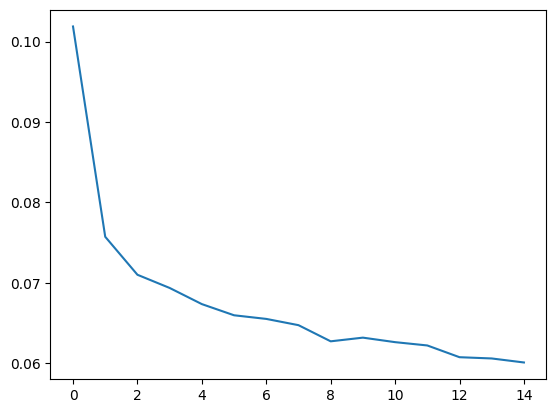

In [100]:
plt.plot(mean_losses)

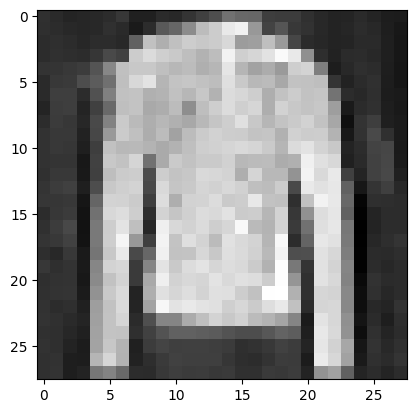

In [102]:
with torch.no_grad():
    # Start from pure noise:
    x = torch.randn((1, 1, 28, 28), device=device)
    
    for t in reversed(range(1, T)):
        # Get the time embedding for step t
        time_emb = embeddings[t].view(1, 1, 28, 28).to(device)
        
        # Predict the noise component for the current sample and timestep
        predicted_noise = model(x, time_emb)
        
        # Get current parameters from the noise schedule:
        alpha_t = alphas[t]            # scalar or tensor of shape [1] 
        alpha_bar_t = alphas_bar[t]      # cumulative product up to t
        beta_t = betas[t]                # variance for step t
        
        # Compute the reverse process mean
        x_mean = (1.0 / torch.sqrt(alpha_t)) * (
                  x - ((1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)) * predicted_noise
                 )        
        if t > 1:
            # Add noise for stochasticity in reverse process:
            noise = torch.randn_like(x)
            sigma_t = torch.sqrt(beta_t)
            x = x_mean + sigma_t * noise
        else:
            x = x_mean  # final step, no noise added

with torch.no_grad():
    plt.imshow(x[0][0].cpu().numpy(), cmap='gray')
    plt.show()